In [3]:
import os
import numpy as np
#from train_lstm_oh import build_model

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model

from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.recurrent import GRU,LSTM
from keras.layers import Input
from keras.layers.convolutional import ZeroPadding3D, Conv2D
from keras import regularizers
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Dropout, Flatten, Dense, Activation
from keras.optimizers import Adam
from keras import backend as K
from keras.applications.vgg16 import VGG16

In [4]:
CURRENT_PATH = os.getcwd()
DATA_PATH = CURRENT_PATH

In [5]:
# load test data
x_path = DATA_PATH + '/X.npz'
y_path = DATA_PATH + '/y.npz'
x_s = np.load(x_path)['x']
y_s = np.load(y_path)['y']
x_train, x_test, y_train, y_test = train_test_split(x_s, y_s, test_size=0.2, shuffle=True)

In [6]:
def build_model(input_size, output_size=28):
    #########################################################
    # Model: conv2d + conv2d + maxpool + dropout + conv2d +
    #  bidirectional gru + dense + softmax + ctc loss
    #########################################################

    ## input_size: placeholder in Keras
    #  shape: (None, seq_size = 20, height = 50, width = 100, channels = 3)
    # if K.image_data_format() == 'channels_first':
    #     input_size = (self.img_c, self.frames_n, self.img_w, self.img_h)
    # else:
    #     input_size = (self.frames_n, self.img_w, self.img_h, self.img_c)

    # self.input_data = Input(name='the_input', shape=input_size, dtype='float32')
    input_data = Input(name='the_input', shape=input_size, dtype='float32')
    
    ## padding used on the height and width before convolving
    #  shape:(None, 20, 54, 104, 3)
    model = Sequential()
    model.add(ZeroPadding3D(padding=(0, 2, 2),input_shape = (input_size), name='padding1'))

    ## 2D Convolution on each time sequence, relu activation
    #  shape 1st conv: (None, 20, 27, 52, 32)
    #  shape 2nd conv: (None, 20, 14, 26, 32)
    model.add(TimeDistributed(Conv2D(filters=34, kernel_size=(3, 3), kernel_initializer='he_normal', strides=(2, 2), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='max1')))

    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', strides=(2, 2), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='max2')))
    model.add(Dropout(0))

    ## 2D Convolution on each time sequence, relu activation
    #  shape 1st conv: (None, 20, 4, 7, 4)
    model.add(TimeDistributed(Conv2D(filters=96, kernel_size=(3, 3), kernel_initializer='he_normal', strides=(2, 2), padding='same', activation='relu')))

    ## Flatten to gru
    #  shape: (None, 20, 112)
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(0.0))
    ## Bidirectional gru
    #  shape: (None, 20, 512)
    # x_lstm = LSTM(256, return_sequences=True, kernel_initializer='Orthogonal', name='lstm1')(input_lstm)
    # x_lstm = LSTM(256, return_sequences=True, kernel_initializer='Orthogonal', name='lstm2')(x_lstm)
    model.add(Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru1'),
                           merge_mode='concat'))
    model.add(Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru2'),
                           merge_mode='concat'))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal', name='fc1', kernel_regularizer=regularizers.l2(0.0)))
    model.add(Dense(output_size, kernel_initializer='he_normal', name='dense2'))

    ## prepare input for ctc loss
    model.add(Activation('softmax', name='softmax'))
    #loss = CTC('ctc', [y_pred, labels, input_length, label_length])
    model.summary()

    return model
def build_model_vgg16(input_size, output_size=28):
    input_data = Input(name='the_input', shape=input_size, dtype='float32')

    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_size[1:], pooling='max')
    x = TimeDistributed(vgg16)(input_data)
    x = TimeDistributed(Flatten())(x)

    # let's add a fully-connected layer
    x = Bidirectional(GRU(256, return_sequences=True, name='gru1'), merge_mode='concat')(x)
    x = Bidirectional(GRU(256, return_sequences=True, name='gru1'), merge_mode='concat')(x)
    x = Flatten()(x)

    x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.2)(x)
    predictions = Dense(output_size, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=input_data, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in vgg16.layers:
       layer.trainable = False
    model.summary()
    return model
def train(model, x_train, y_train, batch_size=256, epochs=100, val_train_ratio=0.2, start_epoch=0):
    ##
    # Train model, typically will train for each speaker
    ## padding the labels
    # max_string_len = 10
    # if y_train.shape[1] != max_string_len:
    #     y_train = pad_labels(y_train, max_string_len)

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    if start_epoch > 0:
        weight_file = os.path.join(CURRENT_PATH, "models/model_lstm_oh.h5")
        model.load_weights(weight_file)
    ## callbacks when each epoch ends
    #  This will ouput character error rate which
    #  compares each predicted word with source word.
    #  TODO: results file need to be implemented
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_train_ratio,
                        shuffle=True,
                        initial_epoch=start_epoch,
                        verbose=1)
    return history

In [7]:
# train model, if there is not a pre trained model
# if already has a model do not train it, this is just for test
# model = build_model_vgg16(x_test.shape[1:], output_size=y_test.shape[1])
# history = train(model, x_train, y_train, batch_size=256, epochs=20,
#                     start_epoch=0)
# model.save('model_lstm_oh.h5')

In [8]:
# change model dir here
model_dir = 'model_vgg16-gru-fc4096-lr0.0001.h5'
model = build_model_vgg16(x_test.shape[1:], output_size=y_test.shape[1])

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
weight_file = os.path.join(CURRENT_PATH, model_dir)
model.load_weights(weight_file)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 21, 50, 100, 3)    0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 512)           14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 512)           1181184   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 512)           1181184   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              44044288  
__________

In [65]:
# choose one sample to test
ind = 18
preds = model.predict(np.expand_dims(x_test[ind],0))
pred_label = np.argmax(preds)
least_label = np.argmin(preds)
true_label = np.argmax(y_test[ind])
print("true label is: ",true_label, "predict label is :", pred_label )
print("true label is: ",true_label, "least label is :", least_label )
# print("probabilities: ",preds)

('true label is: ', 10, 'predict label is :', 10)
('true label is: ', 10, 'least label is :', 13)


In [10]:
# check score for baseline
# prepare for integrated gradient
from scipy.ndimage import imread
sil_img = imread('preprocessing/sil_img.png')
sil_img = np.stack([sil_img for _ in range(x_test[ind].shape[0])], axis =0)
preds = model.predict(np.expand_dims(sil_img,0))
pred_label = np.argmax(preds)
least_label = np.argmin(preds)

## This is a visualization for Saliency Map

In [94]:
from keras.preprocessing import image
from matplotlib import pylab as plt
def show_image(image_new, grayscale = True, ax=None, title=''):
    image = image_new.copy()
    if ax is None:
        plt.figure()
    plt.axis('off')
    
    if len(image.shape) == 2 or grayscale == True:
#         if len(image.shape) == 3:
#             image = np.sum(image, axis=2)
            
#         vmax = np.percentile(image, 99)
#         vmin = np.min(image)

#         plt.imshow(image, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
#         plt.title(title)
        if len(image.shape) == 3:
            image = np.max(np.abs(image), axis = 2)
        plt.imshow(image, cmap=plt.cm.hot)
    else:
        for i in range(3):
            #image = image + 127.5
            rmax = np.max(sil_img[:,:,i])
            rmin = np.min(sil_img[:,:,i])
            vmax = np.max(image[:,:,i])
            vmin = np.min(image[:,:,i])
            image[:,:,i] = (image[:,:,i] - vmin)*(rmax-rmin)/(vmax-vmin)+rmin
        image = image.astype('uint8')
        plt.imshow(image)
        plt.title(title)
    

In [14]:
# (NOT USING) visualization - Vanilla Saliency Map 
from vis.saliency import GradientSaliency
vanilla = GradientSaliency(model,true_label)
least_vanilla = GradientSaliency(model,least_label)
mask_saliency = vanilla.get_mask(x_test[ind])
least_mask_saliency = least_vanilla.get_mask(x_test[ind])

In [15]:
# visualization - guided backpropagation
from vis.guided_backprop import GuidedBackprop
guided_bprop = GuidedBackprop(model,true_label)
least_guided_bprop = GuidedBackprop(model,least_label)
mask = guided_bprop.get_mask(x_test[ind])
least_mask = least_guided_bprop.get_mask(x_test[ind])

In [51]:
# (NOT USING)integrated gradient 
# from vis.integrated_gradients import IntegratedGradients
# inter_grad = IntegratedGradients(model,true_label)
# least_inter_grad = IntegratedGradients(model,least_label)
# mask_integrated = inter_grad.GetMask(x_test[ind], input_baseline = sil_img, nsamples=100)
#least_mask_integrated = least_inter_grad.GetMask(x_test[ind], input_baseline = sil_img, nsamples=100)

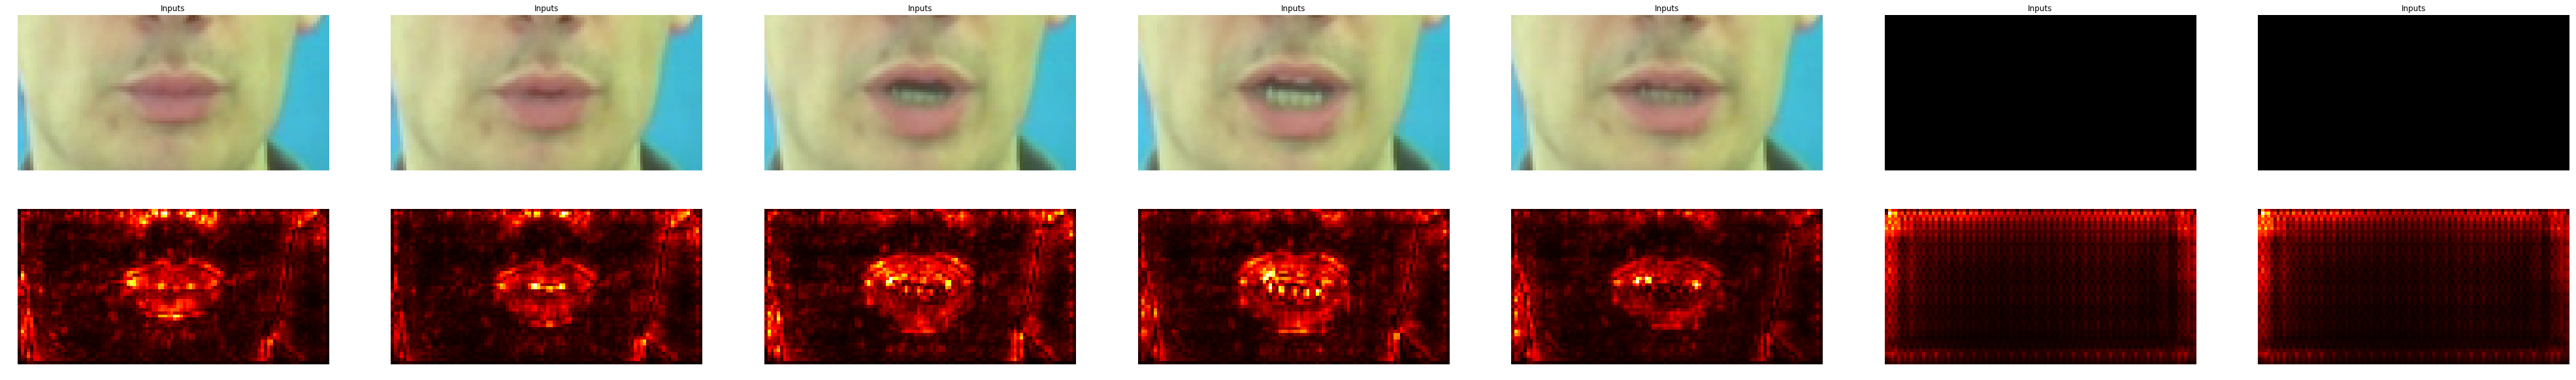

In [19]:
plt.figure(figsize=(70,10))

for i in range(7):
    show_image(mask[i], grayscale = True, ax=plt.subplot(2,7,8+i), title='GuidedBackprop')
    show_image(x_test[ind][i],grayscale = False, ax=plt.subplot(2,7,1+i), title='Inputs')
    #show_image(least_mask[i], ax=plt.subplot(6,7,8+i), title='GuidedBackprop')
# for i in range(7):
#     show_image(mask_saliency[i],grayscale = True, ax=plt.subplot(4,7,15+i), title='GradientSaliency')
#     #show_image(least_mask_saliency[i], ax=plt.subplot(6,7,22+i), title='GradientSaliency')
# for i in range(7):
#     show_image(mask_integrated[i], grayscale = True, ax=plt.subplot(4,7,22+i), title='IntegratedGradients')
#     #show_image(least_mask_integrated[i], ax=plt.subplot(6,7,36+i), title='IntegratedGradients')

## Confusion Matrix

In [9]:
from sklearn.metrics import confusion_matrix

In [25]:
preds = model.predict(x_test)
y_pred = np.argmax(preds, axis = 1)
y_true = np.argmax(y_test, axis = 1)
cm = confusion_matrix(y_true, y_pred, labels = range(51))

In [39]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


#     thresh = cm.max() / 1.5 if normalize else cm.max() / 2
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         if normalize:
#             plt.text(j, i, "{:0.4f}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#         else:
#             plt.text(j, i, "{:,}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

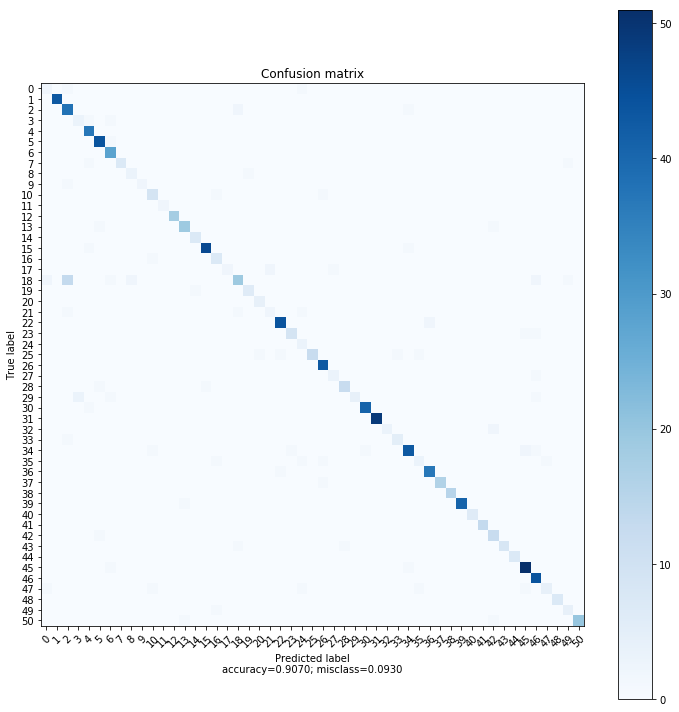

In [41]:

plot_confusion_matrix(cm = cm, target_names = range(51), title='Confusion matrix',
                          normalize=True)

## class visualization

In [144]:
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
def stop_criterion(dx, learning_rate):
    if np.abs(np.min(dx))*learning_rate < 0.01 and np.abs(np.max(dx))*learning_rate < 0.01:
        return True
    else:
        return False
def class_visualization(target_y, model, **kwargs):
    l2_reg = 1e-3
    learning_rate = 1000
    num_iterations = 100
    show_every = 10
    D,H,W,C = sil_img.shape
    #X = np.random.rand(D,H,W,C)
    X = sil_img.astype(float) + np.random.rand(D,H,W,C)*10
    loss = model.output[0][target_y] - l2_reg * tf.nn.l2_loss(model.input)
    gradients = model.optimizer.get_gradients(loss, model.input)
    compute_gradients = K.function(inputs=[model.input,K.learning_phase()], outputs=gradients)
    for t in range(num_iterations):
        #print np.max(X)
        dx = compute_gradients([np.expand_dims(X, axis=0),0])[0][0]
        loss_np = K.function(inputs=[model.input,K.learning_phase()], outputs=[loss,K.learning_phase()])
        loss_np = loss_np([np.expand_dims(X, axis=0),0])[0]
        print np.min(dx),'and', np.max(dx)
        print loss_np
        X += learning_rate * dx
        if loss_np > 0:
            learning_rate = 100
        if t == 0 or (t+1)&show_every == 0 or t == num_iterations - 1 or stop_criterion(dx, learning_rate) == True:
            for frame in range(7):
                show_image(X[frame],grayscale = False, ax=plt.subplot(11,7,(t+1)/show_every*7+frame+1), title='Inputs')
            if stop_criterion(dx, learning_rate) == True:
                return t
    return t

-0.000729553 and 0.000852887
0.0633949
-0.000818761 and 0.000720763
0.110923
-0.00242083 and 0.0021402
0.190102
-0.00273557 and 0.0026039
0.282577
-0.00279179 and 0.0028395
0.4071
-0.00336499 and 0.00378398
0.5475
-0.00233541 and 0.00316135
0.668598
-0.00322332 and 0.00346067
0.740861
-0.00117068 and 0.00152987
0.831575
-0.00119786 and 0.000845163
0.883225
-0.000628443 and 0.000684853
0.909801
-0.000525645 and 0.000644687
0.925041
-0.000420047 and 0.000361924
0.934192
-0.000271094 and 0.000361385
0.940914
-0.00025553 and 0.000214264
0.94547
-0.000208747 and 0.000238442
0.948998
-0.000257001 and 0.000184536
0.951811
-0.000201574 and 0.000388478
0.954375
-0.000239231 and 0.000189829
0.956556
-0.000167138 and 0.000268307
0.958658
-0.000232706 and 0.000138205
0.960174
-0.000130608 and 0.0001243
0.961967
-0.000156668 and 0.000125508
0.963344
-0.000171325 and 0.000310684
0.964471
-0.000282042 and 0.000254759
0.965324
-0.000195295 and 0.00030841
0.966386
-0.0002491 and 0.000219698
0.967129
-0

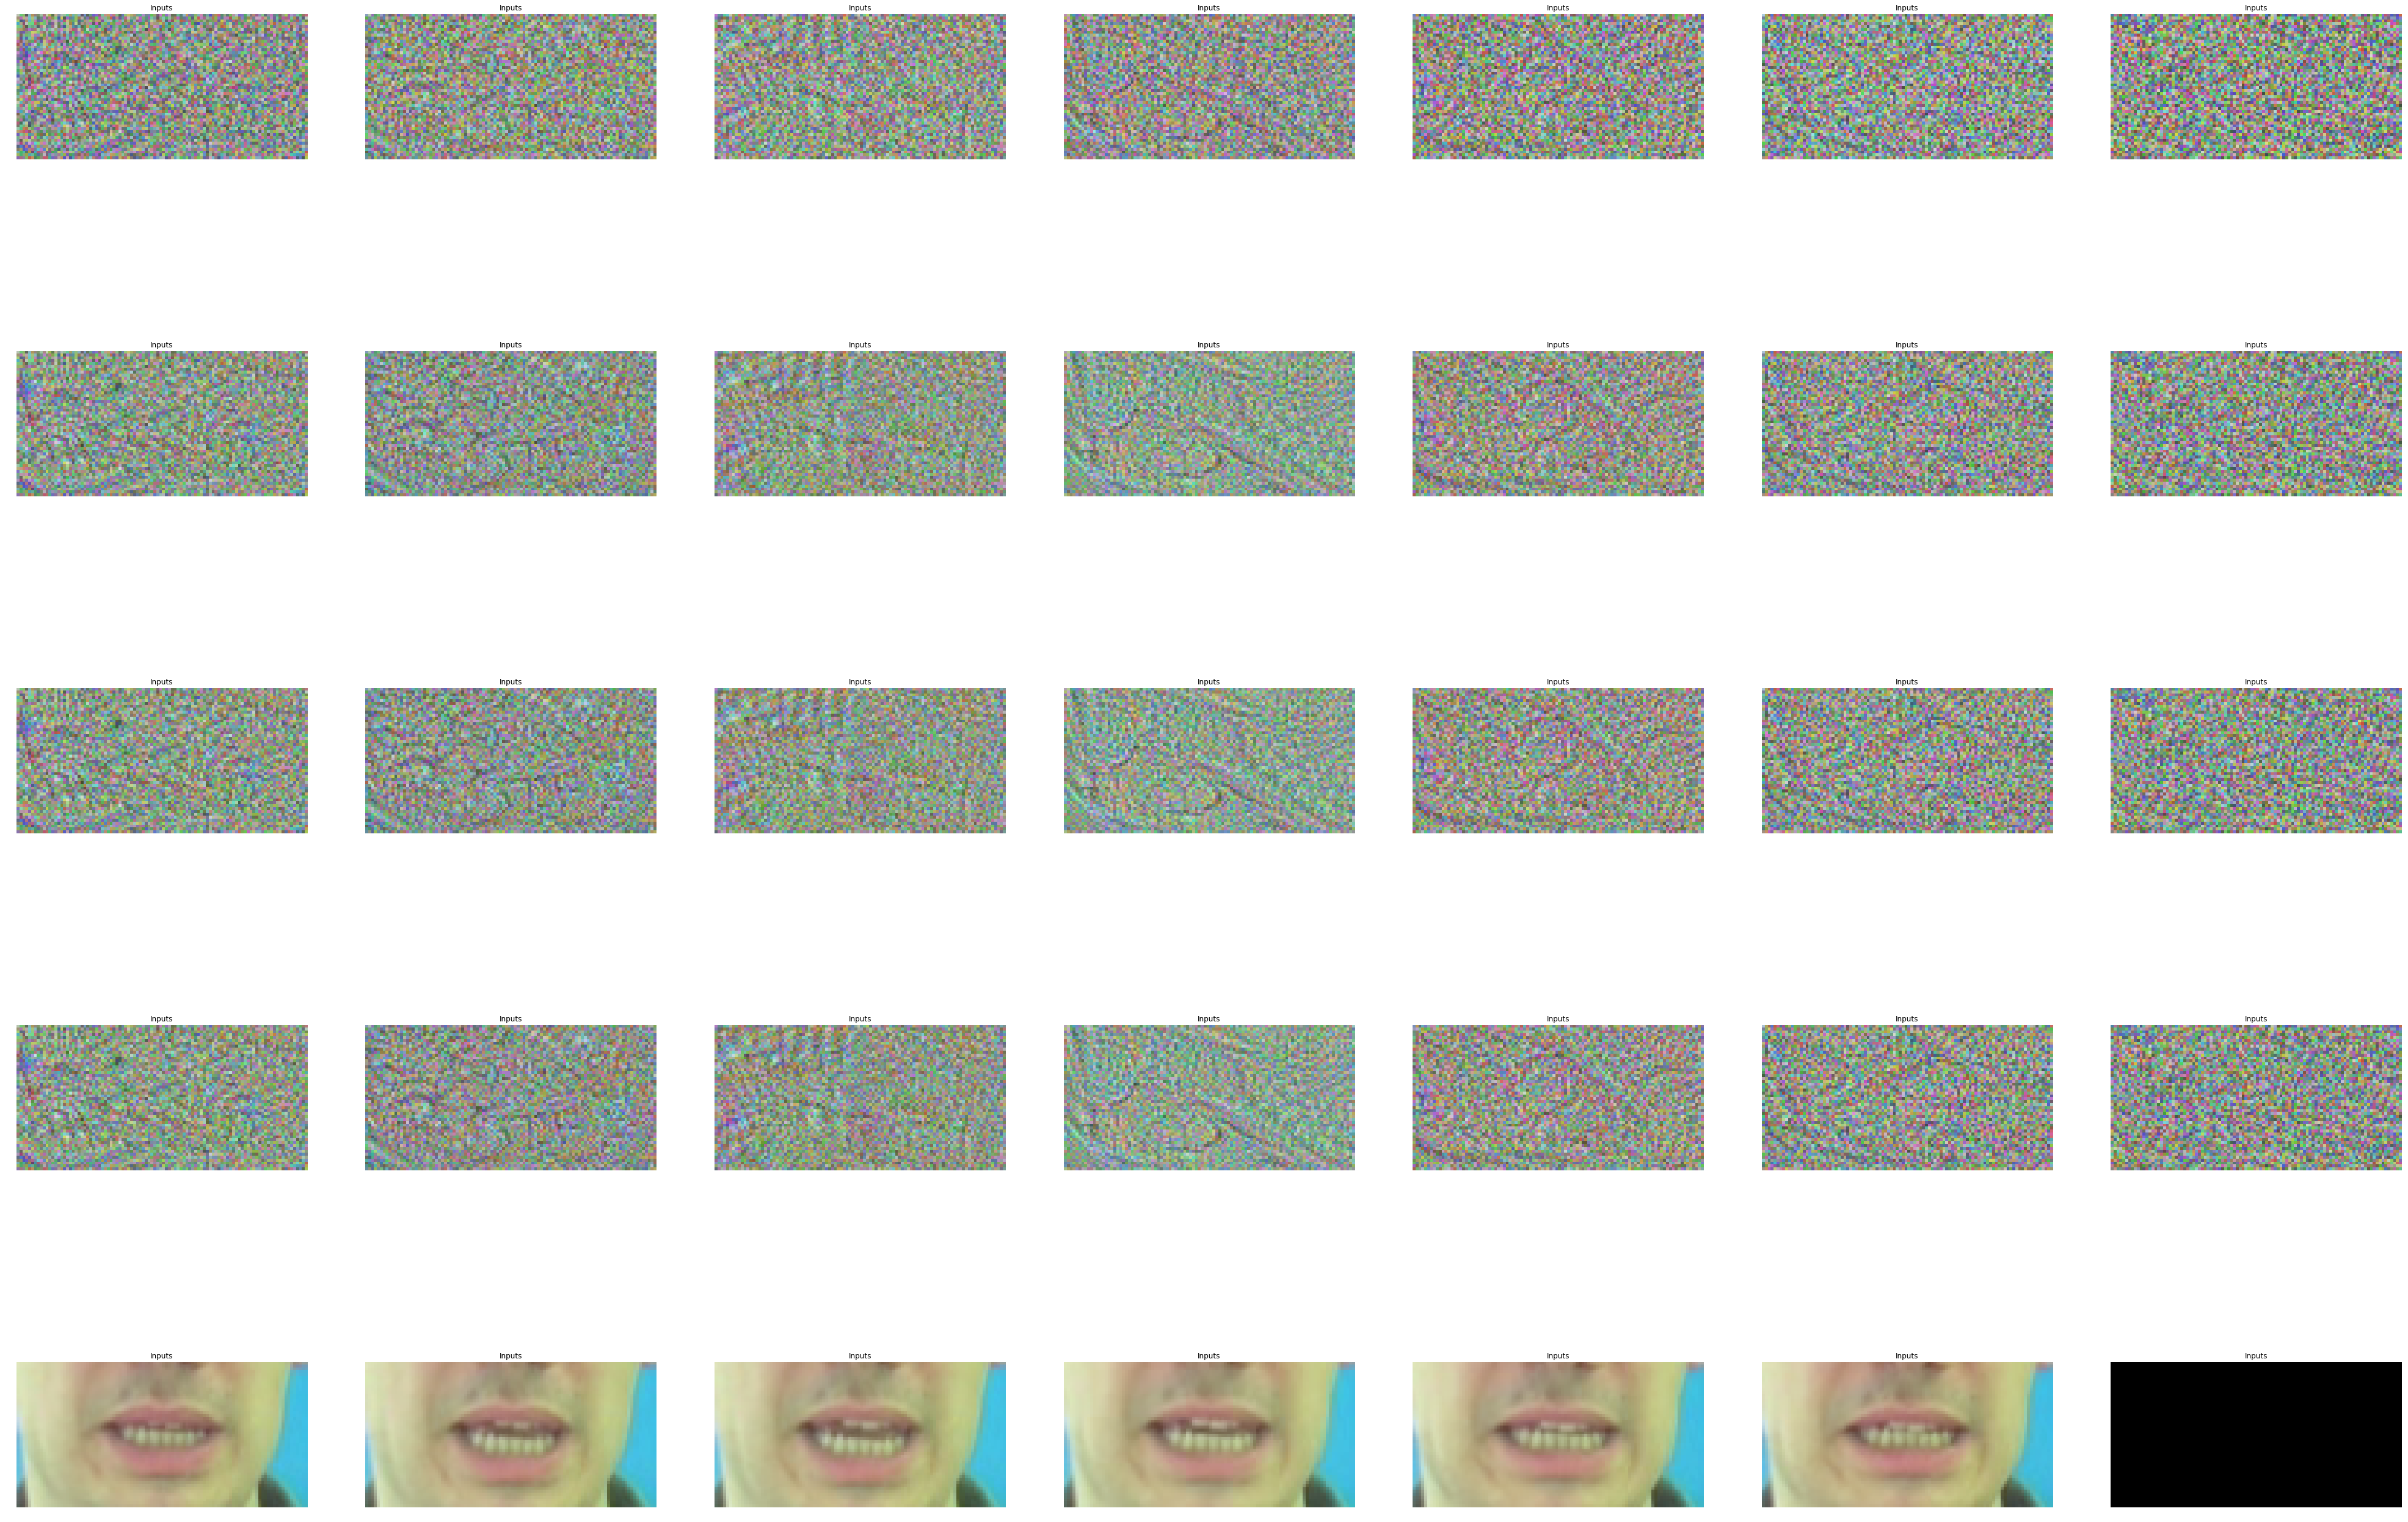

In [120]:
plt.figure(figsize=(70,110))
t = class_visualization(18, model)
for frame in range(7):
    show_image(x_test[ind][frame],grayscale = False, ax=plt.subplot(11,7,(t+1)/10*7+frame+1), title='Inputs')

-0.0242541 and -0.00121729
-342885.0
-0.0218286 and -0.00109556
-277737.0
-0.0196458 and -0.000986004
-224967.0
-0.0176812 and -0.000887404
-182223.0
-0.0159131 and -0.000798664
-147601.0
-0.0143218 and -0.000718798
-119557.0
-0.0128896 and -0.000646918
-96841.0
-0.0116006 and -0.000582226
-78441.2
-0.0104406 and -0.000524004
-63537.3
-0.00939654 and -0.000471603
-51465.3
-0.00845686 and -0.000424443
-41686.8
-0.00761116 and -0.000382001
-33766.3
-0.00685004 and -0.000343801
-27350.7
-0.00616502 and -0.00030942
-22154.1
-0.00554843 and -0.000278477
-17944.8
-0.00499364 and -0.000250632
-14535.3
-0.00449431 and -0.000225569
-11773.6
-0.00404486 and -0.000203016
-9536.62
-0.00364042 and -0.000182712
-7724.66
-0.00327638 and -0.000164435
-6256.97
-0.00294878 and -0.000147991
-5068.15
-0.00265384 and -0.000133191
-4105.2
-0.00238838 and -0.000119871
-3325.21
-0.00214951 and -0.000107887
-2693.42
-0.00193457 and -9.71006e-05
-2181.67
-0.00174117 and -8.73962e-05
-1767.15
-0.00156689 and -7.

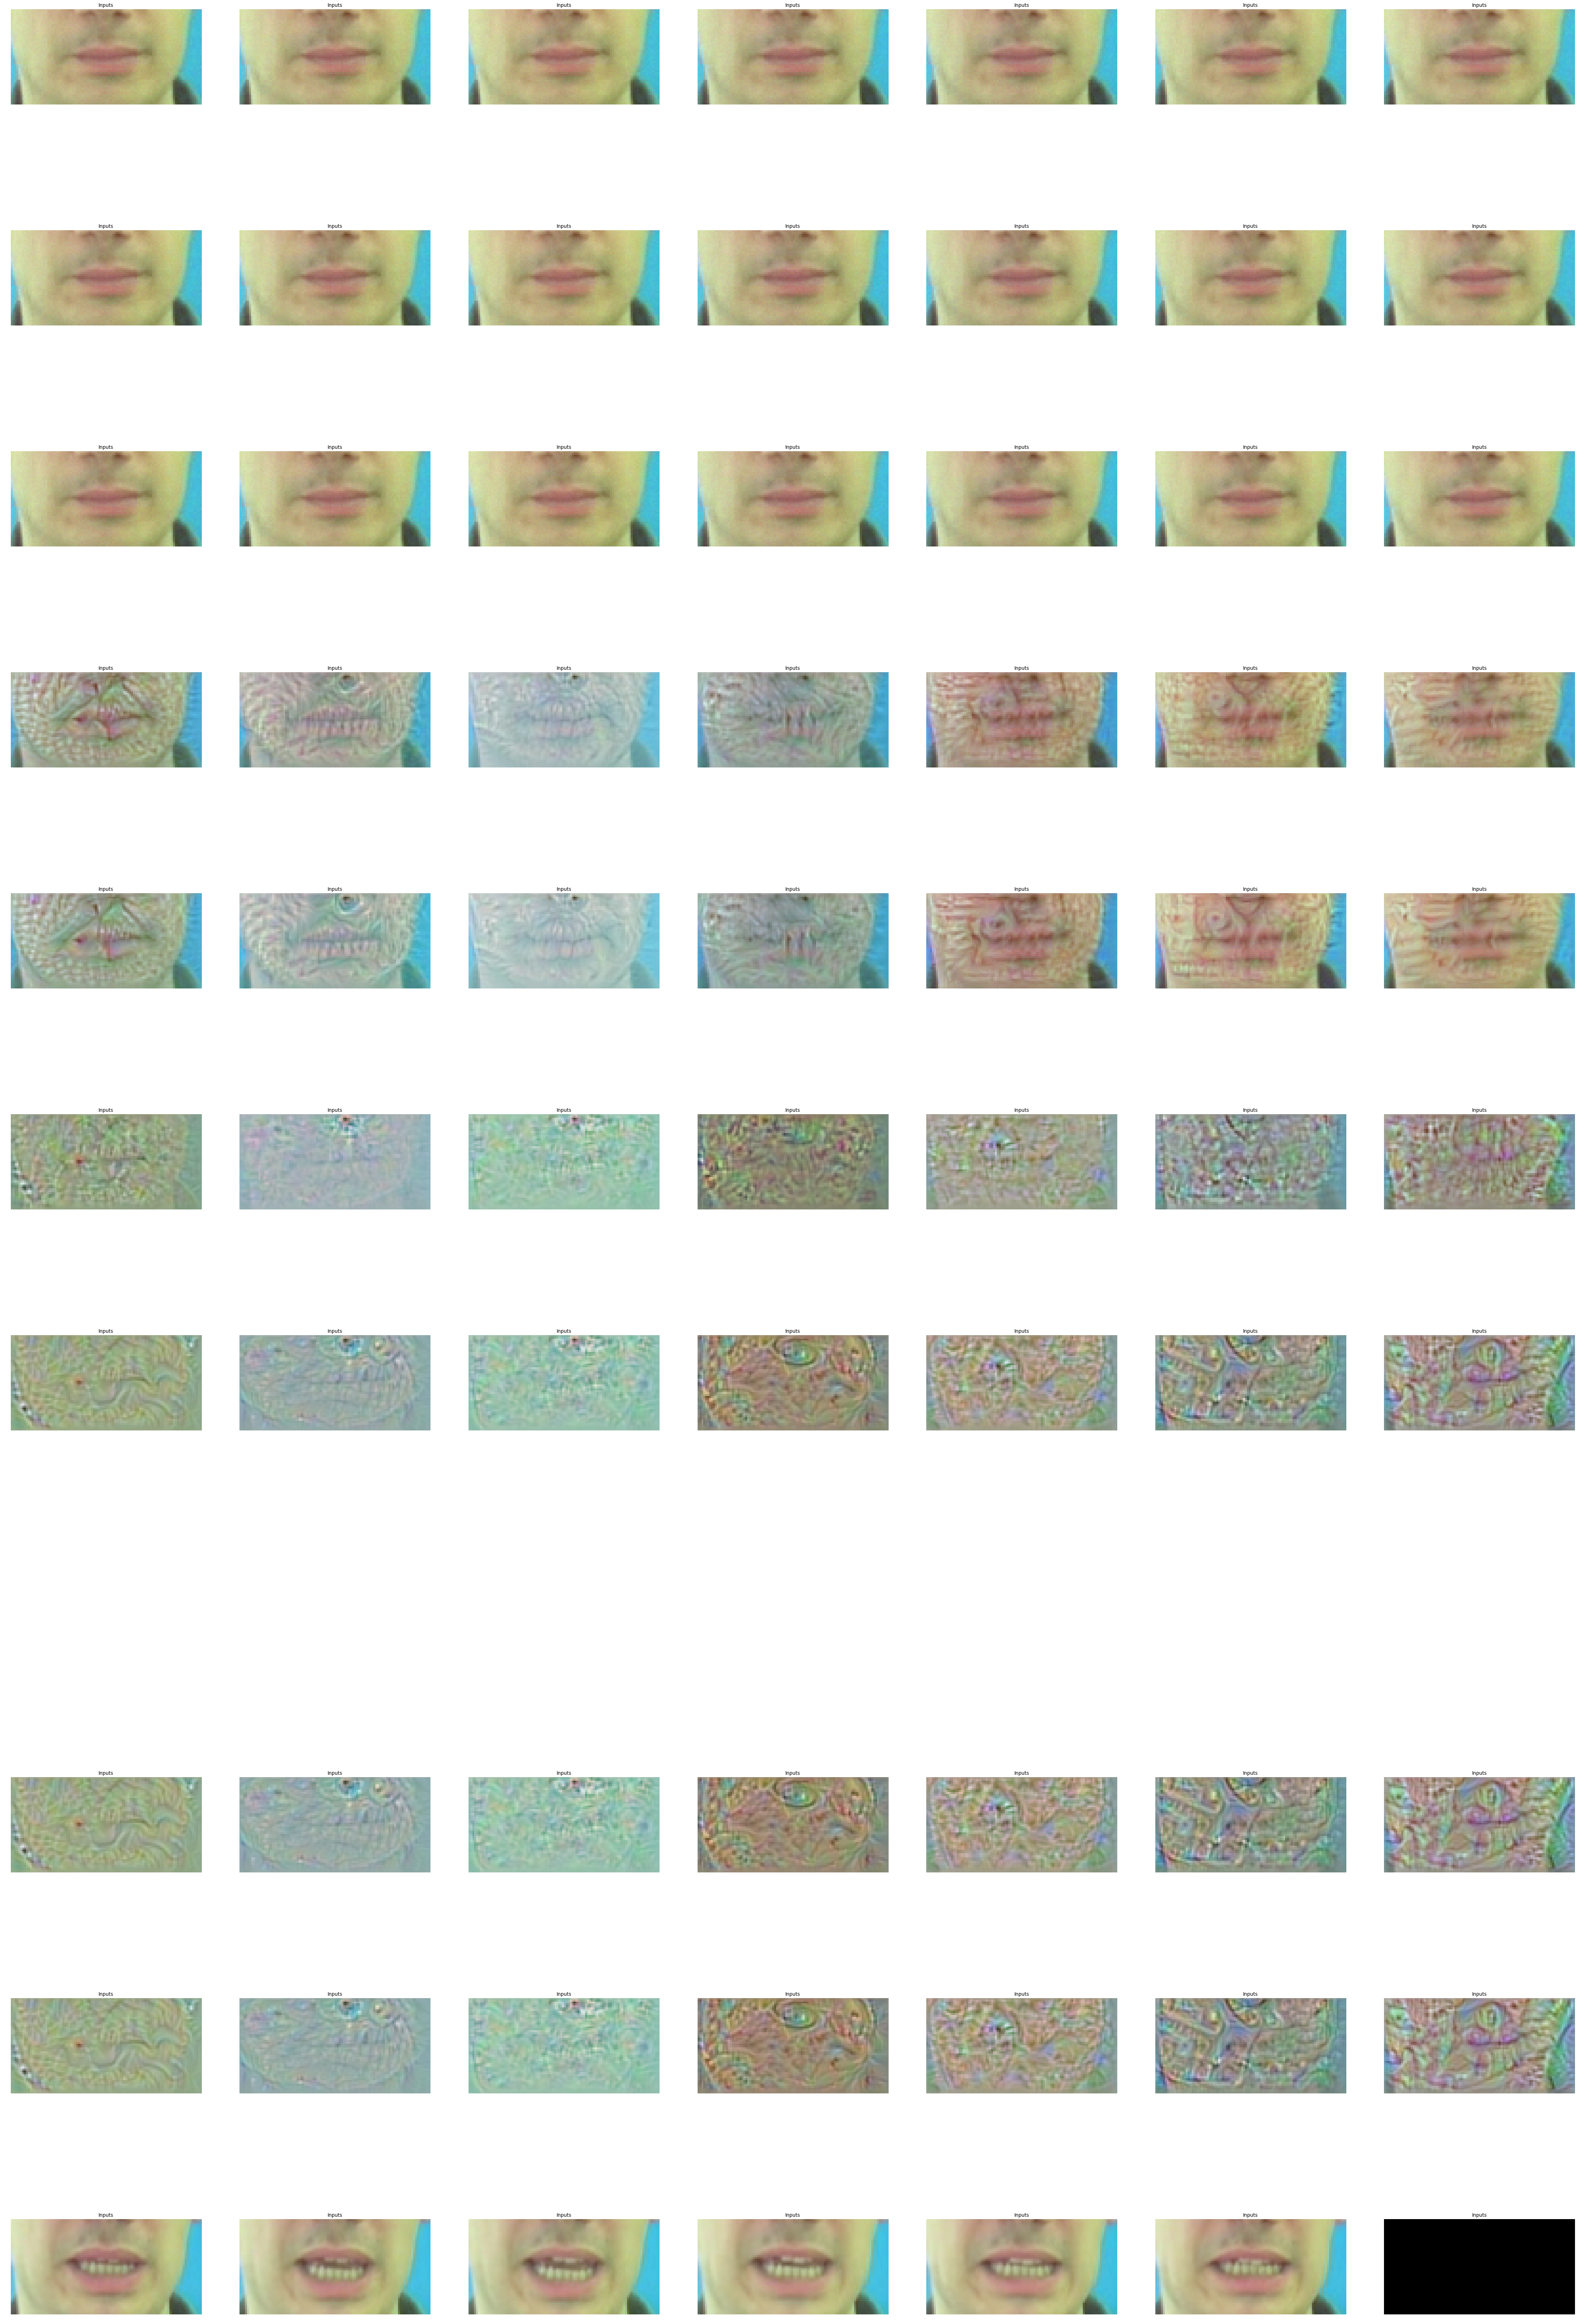

In [135]:
plt.figure(figsize=(70,110))
t = class_visualization(18, model)
for frame in range(7):
    show_image(x_test[ind][frame],grayscale = False, ax=plt.subplot(11,7,(t+1)/10*7+frame+1), title='Inputs')